In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.cm as cm
%matplotlib inline
from scipy.misc import imread, imresize
from PIL import Image
import scipy.io
import os


# # Make sure that caffe is on the python path:
# caffe_root = '../../'  # this file is expected to be in {caffe_root}/examples/hed/
# import sys
# sys.path.insert(0, caffe_root + 'python')

import caffe

In [2]:
img = imread('../../../tiger/z19-800/test/10292.png', mode='RGB')
lmap = imread('../../../tiger/z19-800/test/10292.ppm')
in_ = np.array(img, dtype=np.float32)
in_ = in_[:, :, ::-1] - np.array([104.00698793,116.66876762,122.67891434])
in_ = in_.transpose([2, 0, 1])

In [3]:
# set up
caffe.set_mode_gpu()
caffe.set_device(0)
# load net
net = caffe.Net('deploy.prototxt', 'hed_iter_30000.caffemodel', caffe.TEST)
# net = caffe.Net('deploy.prototxt', 'hed_pretrained_bsds.caffemodel', caffe.TEST)
# shape for input (data blob is N x C x H x W), set data
net.blobs['data'].reshape(1, *in_.shape)
net.blobs['data'].data[...] = in_
# run net and take argmax for prediction
net.forward()
# out1 = net.blobs['sigmoid-dsn1'].data[0][0,:,:]
# out2 = net.blobs['sigmoid-dsn2'].data[0][0,:,:]
# out3 = net.blobs['sigmoid-dsn3'].data[0][0,:,:]
# out4 = net.blobs['sigmoid-dsn4'].data[0][0,:,:]
# out5 = net.blobs['sigmoid-dsn5'].data[0][0,:,:]
fuse = net.blobs['sigmoid-fuse'].data[0][0,:,:]

# scale_lst = [fuse]
# plot_single_scale(scale_lst, 22)
# scale_lst = [out1, out2, out3, out4, out5]
# plot_single_scale(scale_lst, 10)

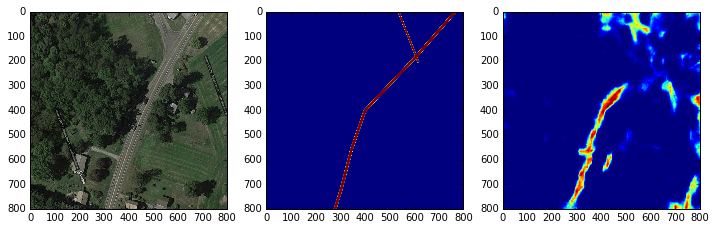

In [4]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(lmap)
plt.subplot(133)
plt.imshow(fuse)

# Small aerial image

In [13]:
w, h, c = 800, 800, 3
image = imread('../../../tiger/final-8k/final_0.png', mode='RGB')
lmap = imread('../../../tiger/lines-png/final_0.png', mode='RGBA')[:, :, 3]
print image.shape

(8000, 8000, 3)


In [5]:
H, W, _ = image.shape
nh, nw = H/h, W/w
patches = image[:, :, ::-1] - np.array([104.00698793,116.66876762,122.67891434])
# ho, wo, c, hi, wi
patches = patches.reshape(nh, h, nw, w, -1).transpose([0, 2, 4, 1, 3])

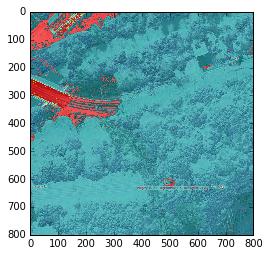

In [12]:
patch = patches[0, 0].transpose(1, 2, 0) 
#patch += np.array([108.353, 115.294, 114.578])
#patch = patch[:, :, ::-1]
plt.imshow(patch)

In [6]:
probs = np.zeros([nh, nw, h, w], dtype=float)
labels = np.zeros([nh, nw, h, w], dtype=int)
for ho in xrange(nh):
    sys.stdout.write(str(ho)+' ')
    sys.stdout.flush()
    for wo in xrange(nw):
        net.blobs['data'].reshape(1, c, h, w)
        net.blobs['data'].data[...] = patches[ho, wo, ...]
        net.forward()
        probs[ho, wo] = net.blobs['sigmoid-fuse'].data[0]
        labels[ho, wo] = probs[ho, wo] > 0.5

0 1 2 3 4 5 6 7 8 9 

In [7]:
probs = probs.transpose([0, 2, 1, 3])
labels = labels.transpose([0, 2, 1, 3])
print probs.shape
probs = probs.reshape(H, W)
labels = labels.reshape(H, W)
print probs.shape

(10, 800, 10, 800)
(8000, 8000)


(-0.5, 799.5, 799.5, -0.5)

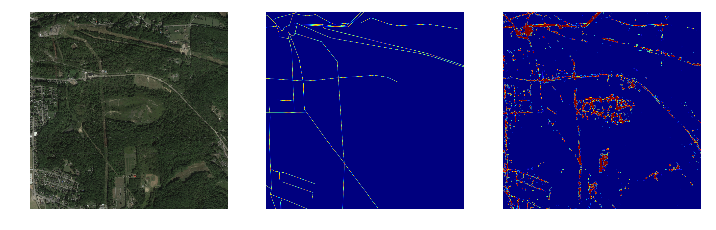

In [14]:
image_small = imresize(image, (800, 800))
probs_small = imresize(probs, (800, 800))
lmap_small = imresize(lmap, (800, 800))
labels_small = imresize(labels, (800, 800))

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.imshow(image_small)
plt.axis("off")

plt.subplot(132)
plt.imshow(lmap_small)
plt.axis('off')

plt.subplot(133)
plt.imshow(labels_small)
plt.axis("off")

# Autograd

In [5]:
import autograd.numpy as np   # Thinly-wrapped version of Numpy
from autograd import grad

# basis takes a lot of space
# conduct Hough on a small image
h, w = 80, 80
rho_range, theta_range = 240, 180
basis = np.zeros([h, w, rho_range, theta_range], dtype=int)

theta_min, theta_max = -90., 90.
rho_max = float(np.sqrt(w**2+h**2))
rho_min = -rho_max
theta_step = (theta_max - theta_min) / theta_range
rho_step = (rho_max - rho_min) / rho_range

# cache sin/cos
thetas = np.array([theta_min+i*theta_step for i in xrange(theta_range)])
cos = lambda x: np.cos(np.deg2rad(x))
sin = lambda x: np.sin(np.deg2rad(x))
cos_ = cos(thetas)
sin_ = sin(thetas)

for y in xrange(h):
    for x in xrange(w):
        rho_ = ((x*cos_+y*sin_+rho_max)/rho_step).astype(int)
        basis[y, x, rho_, range(theta_range)] = 1

def my_hough(img):
    assert h, w == img.shape
    hf = np.zeros([rho_range, theta_range], dtype=float)
    
    # discrete
#     ys, xs = np.nonzero(img)
#     for y, x in zip(ys, xs):
#         hf = hf + basis[y, x]
    
    # continuous
    for y in xrange(h):
        for x in xrange(w):
            hf = hf + img[y, x] * basis[y, x]
    
    return hf

# tgt
tgt = imresize(lmap, [w, h]).astype(float)/255.
hf_tgt = my_hough(tgt)

def hough_loss(prob):
    hf_pred = my_hough(prob)
    loss = np.sum((hf_pred-hf_tgt)**2)
    return loss

hough_grad = grad(hough_loss)

In [6]:
out = imresize(fuse, [w, h]).astype(float)/255.
loss = hough_loss(out)
grad = hough_grad(out)
print 'loss:', loss
print 'min/max grad:', np.min(grad), np.max(grad)

loss: 146654.518416
min/max grad: -253.482352941 1786.0627451


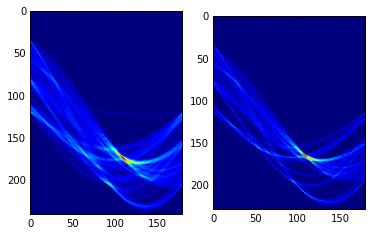

In [19]:
from skimage.transform import hough_line
hout = my_hough(out)
href, _, _ = hough_line(out>.5)
plt.subplot(121)
plt.imshow(hout)
plt.subplot(122)
plt.imshow(href)

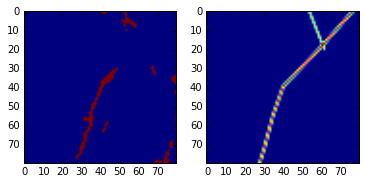

In [20]:
plt.subplot(121)
plt.imshow(out>.5)
plt.subplot(122)
plt.imshow(tgt)

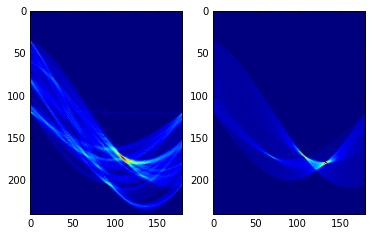

In [21]:
plt.subplot(121)
plt.imshow(hout)
plt.subplot(122)
plt.imshow(my_hough(tgt))

# Numerical gradient

In [19]:
import numpy as np
import sys

def gradient(func, x, eps=1e-6):
    r = np.zeros_like(x, dtype=float)
    rf = r.reshape(-1)
    xf = x.reshape(-1)
    for i in xrange(len(xf)):
        if i % 10 == 0:
            sys.stdout.write('{} '.format(i))
        if i > 0 and i % 100 == 0:
            print
        xf[i] += eps
        f2 = func(x)
        xf[i] -= 2*eps
        f1 = func(x)
        xf[i] += eps
        rf[i] = (f2 - f1) / (2 * eps)
    return r

In [20]:
grad_num = gradient(hough_loss, out)

0 10 20 30 40 50 60 70 80 90 100 
110 120 130 140 150 160 170 180 190 200 
210 220 230 240 250 260 270 280 290 300 
310 320 330 340 350 360 370 380 390 400 
410 420 430 440 450 460 470 480 490 500 
510 520 530 540 550 560 570 580 590 600 
610 620 630 640 650 660 670 680 690 700 
710 720 730 740 750 760 770 780 790 800 
810 820 830 840 850 860 870 880 890 900 
910 920 930 940 950 960 970 980 990 1000 
1010 1020 1030 1040 1050 1060 1070 1080 1090 1100 
1110 1120 1130 1140 1150 1160 1170 1180 1190 1200 
1210 1220 1230 1240 1250 1260 1270 1280 1290 1300 
1310 1320 1330 1340 1350 1360 1370 1380 1390 1400 
1410 1420 1430 1440 1450 1460 1470 1480 1490 1500 
1510 1520 1530 1540 1550 1560 1570 1580 1590 1600 
1610 1620 1630 1640 1650 1660 1670 1680 1690 1700 
1710 1720 1730 1740 1750 1760 1770 1780 1790 1800 
1810 1820 1830 1840 1850 1860 1870 1880 1890 1900 
1910 1920 1930 1940 1950 1960 1970 1980 1990 2000 
2010 2020 2030 2040 2050 2060 2070 2080 2090 2100 
2110 2120 2130 2140 2150 2160 2170 

In [21]:
diff = grad_num - grad
print diff.min(), diff.max()

-0.000232494358897 0.000248930998623


In [22]:
np.save('grad_00000', grad_num)

# Visualize gradient

In [22]:
grad_sp = out - tgt

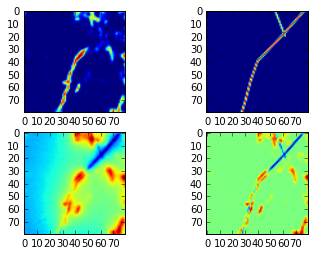

In [23]:
plt.subplot(221)
plt.imshow(out)
plt.subplot(222)
plt.imshow(tgt)
plt.subplot(223)
plt.imshow(grad)
plt.subplot(224)
plt.imshow(grad_sp)

In [32]:
print out.min(), out.max()
print tgt.min(), tgt.max()

0.0 0.988235294118
0.0 1.0


# Manual gradient

In [25]:
import numpy as np

def hough_grad_man(prob):
    h, w = 80, 80
    assert h, w == prob.shape
    r = (out-tgt).reshape(h, w, 1, 1)*basis
    r = r.sum(axis=(0, 1))
    r = 2 * basis * r
    r = r.sum(axis=(2, 3))
    return r

In [ ]:
grad_man = hough_grad_man(out)